# Price Trajectories for Cryptos

In [2]:
#Libraries
import pandas as pd
import numpy as np
import cvxopt
from functools import partial
import math
import numpy as np
import scipy
from scipy import stats
from scipy.stats import lognorm
from scipy.stats import t
from scipy.optimize import Bounds
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera
import matplotlib.pyplot as plt
from arch.univariate import EWMAVariance,ZeroMean

C:\nconda\lib\site-packages\scipy\__init__.py:137: UserWarning: NumPy 1.16.5 or above is required for this version of SciPy (detected version 1.16.4)
  UserWarning)


In [3]:
#Load daily historical series
btc_d = pd.read_excel('Ethereum.xlsx', sep=',',index_col=[0], parse_dates=True)

In [4]:
btc_d.head()

,RETORNOS,VOLUMEN,PRECIO
DATES,,,
2015-08-08,-0.728249,674188,0.753325
2015-08-09,-0.068268,532170,0.701897
2015-08-10,0.009333,405283,0.708448
2015-08-11,0.507323,1463100,1.067860
2015-08-12,0.140075,2150620,1.217440


C:\nconda\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


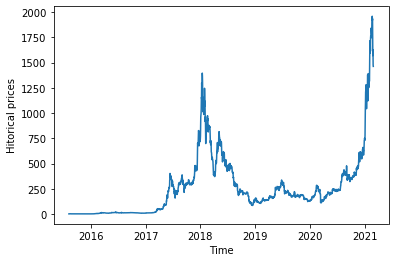

In [5]:
plt.plot(btc_d.index, btc_d.PRECIO)
plt.xlabel('Time')
plt.ylabel('Hitorical prices')
plt.show()

## Estimate parameter of Geometric Brownian Motion for historical data

Let $dX_{t}=\alpha X_{t}dt+\sigma X_{t}dW_{t}$, $X_{0}=x_{0}>0$, if $Z_{t}=\ln X_{t}$ $\Rightarrow$ by Ito
\begin{align*}
dZ_{t}&=& 0+\frac{\alpha X_{t}}{X_{t}}dt + \frac{\sigma X_{t}}{X_{t}}dW_{t}+\frac{1}{2}(\frac{1}{X_{t}^{2}})\sigma^{2}X_{t}^{2}dt\\
&=& (\alpha -\frac{\sigma^{2}}{2})dt + \sigma dW_{t}
\end{align*}
Then
\begin{align*}
  \ln X_{t}&=& Z_{t} \sim N((\alpha -\frac{\sigma^{2}}{2})t, \sigma^{2}t)\\
  X_{t}&=& x_{0}\exp((\alpha -\frac{\sigma^{2}}{2})t+\sigma W_{t})
\end{align*}
log Gaussian Kernel
\begin{align*}
p(t,y \mid x_{0}; \alpha, \sigma)&=&\frac{1}{y \sigma \sqrt{2 \pi}}\exp(-\frac{(\log y-\mu)^{2}}{2\sigma^{2}})\\
&=&\frac{1}{y \sigma \sqrt{2 \pi}t}\exp(-\frac{(\log y-(\log x_{0}+(\alpha - \frac{\sigma^{2}}{2})t))^{2}}{2\sigma^{2}t})
\end{align*}
Find $\alpha_{ML}$ and $\sigma_{ML}$ numerically.

In [6]:
def neg_log_like_GBM(y,theta):
    dt = 0.01
    x0 = y[:-1]
    ml= np.log(x0)+(theta[0]-0.5*theta[1]**2)*dt
    sl= np.sqrt(dt)*theta[1]
    loglike= np.sum(lognorm.logpdf(y[1:], s=sl,loc=0,scale=np.exp(ml)))
    return -loglike

In [7]:
neg_log_like_GBM(btc_d.PRECIO,(0.5,0.5))

6380.4287102319795

In [8]:
objective = partial(neg_log_like_GBM, btc_d.PRECIO)
bounds = Bounds([-10.0, 0.01], [10.0, 10.0])

In [9]:
# Actually do the minimization
result = scipy.optimize.minimize(objective, (1, 1), method='trust-constr', bounds=bounds)
theta_mle = result.x
print('theta MLE: ' + str(theta_mle))

theta MLE: [0.5655737  0.61914972]


## Simulate Geometric Brownian Motion, Appendix Gauntlet (2020)
Using the solution for the SDE we can get an exact form to sumultate the process,
\begin{equation*}
X_{t}= x_{0}\exp((\alpha -\frac{\sigma^{2}}{2})t+\sigma W_{t})
\end{equation*}
the we can simulate teh values of $X_{t}$ for $t=1,\ldots,T$
\begin{equation*}
X_{t+1}= X_{t}\exp((\alpha -\frac{\sigma^{2}}{2})(t+1-t)+\sigma \sqrt{t+1-t} Z_{t+1})
\end{equation*}
where $Z_{1},\ldots,Z_{T}$ are independent standard normals.

In [10]:
def sim_GBM(S0,mu,sigma,dt,T):
    Z=np.random.normal(loc=0.0, scale=1, size=T)
    y = np.ndarray(T)
    y[0]=S0
    for t in range(1, T):
        y[t] = y[t-1]*np.exp((mu-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*Z[t])
    return y

In [11]:
path1=sim_GBM(250,theta_mle[0],theta_mle[1],0.01,100)

In [12]:
path1

array([250.        , 233.81353979, 219.01101542, 233.01260941,
       232.74156713, 206.97516902, 203.06897724, 236.99874047,
       220.6395206 , 226.16818703, 210.89220397, 217.12632807,
       202.71793728, 189.60046927, 201.63122593, 200.12949266,
       198.01809693, 188.31116171, 193.68652866, 207.57831969,
       220.87715186, 237.91605134, 230.35756016, 244.9867917 ,
       216.39746214, 236.12359598, 210.55335125, 208.81231125,
       207.39899843, 223.11423652, 225.19597904, 221.45460251,
       200.3574702 , 192.94222334, 204.32851669, 183.86698815,
       175.00300632, 167.36629794, 177.89876318, 174.20327876,
       175.76362367, 183.58193665, 175.45263279, 180.67761513,
       167.68930445, 173.73983715, 164.09004312, 161.33358786,
       143.29924776, 158.4451011 , 169.1733144 , 171.10933825,
       162.60023465, 159.24634837, 157.56807428, 174.32428247,
       205.27834512, 208.34926918, 207.51337463, 206.21859398,
       216.66666868, 228.44652775, 235.39368175, 226.33

In [16]:
Nsim=120
paths=pd.DataFrame(columns=range(Nsim))
for i in range(Nsim):
    paths.iloc[:,i]=sim_GBM(500,theta_mle[0],theta_mle[1],0.01,100)
    #paths.iloc[:,i]=sim_GBM(20000,theta_mle[0],0.2,0.01,100)

In [17]:
paths.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
1,435.026600,501.349214,496.541125,534.159868,517.197516,483.103278,487.985861,510.784966,494.457902,478.611105,...,484.047124,522.064121,511.440888,522.729039,455.906464,474.718159,484.532126,486.876404,445.000436,460.430474
2,444.505605,489.569021,520.074536,578.662776,512.189445,501.269376,455.813819,524.996729,510.164829,497.694734,...,481.538518,499.727073,521.386801,515.473685,456.775798,435.521521,450.612710,488.795373,475.034930,492.052151
3,451.623001,510.595805,494.792661,606.823680,481.787024,481.055820,485.364191,498.789330,592.166242,474.820110,...,474.386951,548.296030,508.053508,554.303253,453.154074,471.113087,445.091576,483.594514,457.442280,462.092596
4,471.300325,536.511345,505.585986,602.469822,498.660453,530.204965,462.065847,478.326459,593.001946,462.069160,...,489.810664,535.361301,579.556692,620.459117,491.351119,526.361549,466.853213,456.824862,436.533842,493.091218


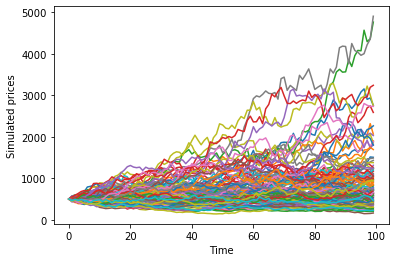

In [18]:
#simulated prices
plt.plot(range(100), paths)
plt.xlabel('Time')
plt.ylabel('Simulated prices')
plt.show()

## Time varying Volatility GARCH(1,1) where EWMA is a particular case

Let $\lambda \in (0,1)$ denote the strenght of autocorrelation in volatility process.
\begin{equation*}
\sigma_{t}^{2} =\lambda\sigma_{t-1}^{2}+(1-\lambda)r_{t-1}^{2}
\end{equation*}
Volatility estimate for day $t$ is given by: the previous estimate $\sigma_{t-1}$ and most recent change in the return process $r_{t-1}$.

In [19]:
#Log Returns
ret=np.log(btc_d.PRECIO).diff(periods=1)*100
ret=ret[1:]

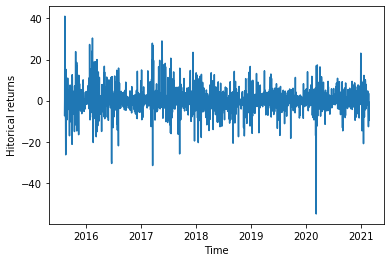

In [20]:
plt.plot(btc_d.index[1:], ret)
plt.xlabel('Time')
plt.ylabel('Hitorical returns')
plt.show()

In [21]:
ret0=ZeroMean(ret)
ret0.volatility=EWMAVariance(lam=0.95)
ewma=ret0.fit()

In [22]:
daily_std=np.sqrt(ewma.conditional_volatility/100)#*np.sqrt(252) #yealy

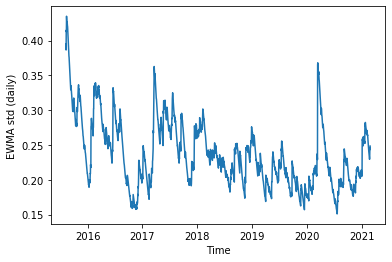

In [23]:
plt.plot(daily_std.index, daily_std)
plt.xlabel('Time')
plt.ylabel('EWMA std (daily)')
plt.show()

In [24]:
daily_std.describe()

count    2025.000000
mean        0.237028
std         0.048286
min         0.150863
25%         0.200394
50%         0.228139
75%         0.268867
max         0.434915
Name: cond_vol, dtype: float64

## Stochastic Volatility with a correlated jump Huo et al (2020)

\begin{align*}
dlogS_{t}=\mu dt + \sqrt{V_{t}}dW_{t}^{S}+Z_{t}^{\gamma}dN_{t}
\end{align*}
\begin{align*}
dV_{t}=\kappa(\theta-V_{t})dt + \sigma_{V}\sqrt{V_{t}}dW_{t}^{V}+Z_{t}^{v}dN_{t}
\end{align*}
\begin{align*}
Cov(dW_{t}^{S},dW_{t}^{V})=\rho dt
\end{align*}
\begin{align*}
P(dN_{t}=1)=\lambda dt
\end{align*}
where $N_{t}$ is a pure jump process with a constant mean-jump arrival rate. Note that Scaillet et al (2020) have identified jumps in the Bitcoin price process using intraday data.